Load Julia packages (libraries) needed.

In [1]:
using StatisticalRethinking, CmdStan
gr(size=(600,600));

ProjDir = rel_path("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [2]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';');
df = convert(DataFrame, wd);
df[:A] = scale(df[:MedianAgeMarriage]);
df[:D] = scale(df[:Divorce]);
first(df, 5)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:3
└ @ Core string:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at string:3
└ @ Core string:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:4
└ @ Core string:4
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at string:4
└ @ Core string:4


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce
,String,String,Float64,Float64,Float64,Float64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5
5,California,CA,37.25,26.8,19.1,0.39,8.0


### snippet 5.1

In [3]:
std(df[:MedianAgeMarriage])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1


1.2436303013880823

Define the Stan language model

In [4]:
#=
m5.1.1 <- ulam(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bA * A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = list(A=d$MedianAgeMarriage.s,
      D=d$Divorce.s), chain=4 )
precis(m5.1.1)
=#

ad = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] D; // Outcome
 vector[N] A; // Predictor
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  vector[N] mu;
  # priors
  a ~ normal(0, 0.2);
  bA ~ normal(0, 0.5);
  sigma ~ exponential(1);
  # likelihood
  mu = a + bA * A;
  D ~ normal(mu , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [5]:
m5_1s = Stanmodel(name="MedianAgeDivorce", model=ad);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/05/tmp/MedianAgeDivorce.stan will be updated.



Input data for cmdstan

In [6]:
data = Dict("N" => length(df[:D]), "D" => df[:Divorce],
    "A" => df[:A]);
# Sample using cmdstan
rc, chn, cnames = stan(m5_1s, data, ProjDir, diagnostics=false,
  summary=true, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/05/tmp/MedianAgeDivorce.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecifi

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼───────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ a          │ 0.23803   │ 0.20362  │ 0.00321952 │ 0.00361702 │ 3120.12 │
│ 2   │ bA         │ -0.134013 │ 0.468181 │ 0.0074026  │ 0.00736563 │ 3411.18 │
│ 3   │ sigma      │ 9.03692   │ 0.830419 │ 0.0131301  │ 0.0132712  │ 3621.28 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%     │ 50.0%     │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64   │ Float64   │ Float64  │ Float64  │
├─────┼────────────┼──────────┼───────────┼───────────┼──────────┼──────────┤
│ 1   │ a          │ -0.16399 │ 0.105538  │ 0.237837  │ 0.380475 │ 0.627199 │
│ 2   │ bA         │ -1.06467 │ -0.448394 │ -0.137034 │ 0.178641 │ 0.802697 │
│ 3   │ sigma      │ 7.5341   │ 

Plot the density of posterior draws

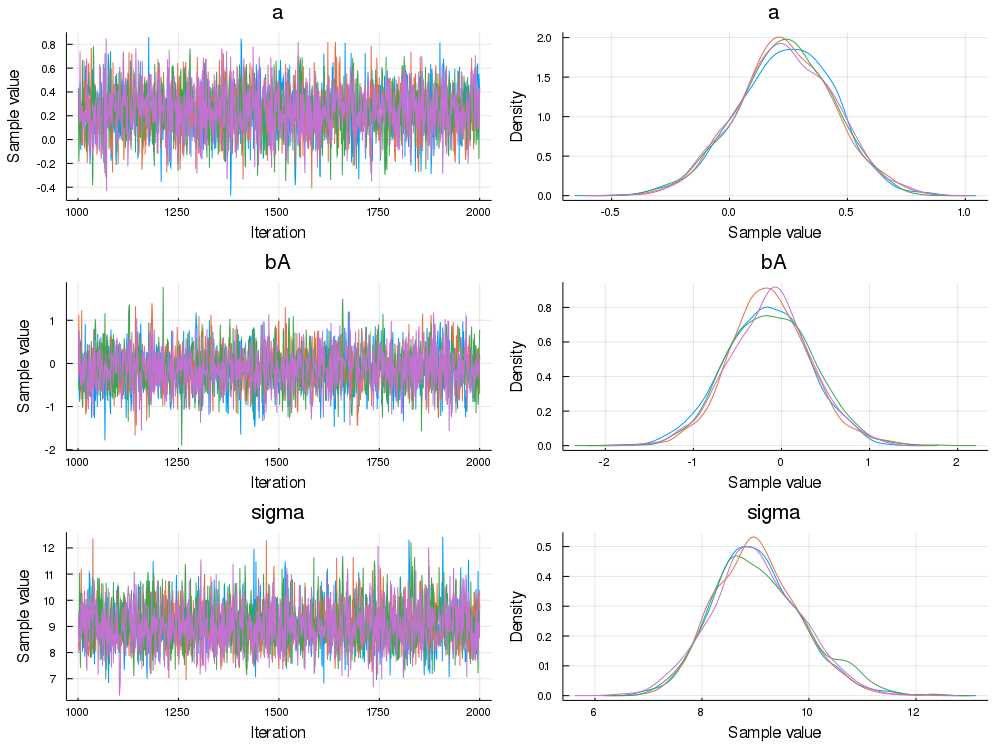

In [7]:
plot(chn)

Result rethinking

In [8]:
rethinking = "
       mean   sd  5.5% 94.5% n_eff Rhat
a      9.69 0.22  9.34 10.03  2023    1
bA    -1.04 0.21 -1.37 -0.71  1882    1
sigma  1.51 0.16  1.29  1.79  1695    1
"

"\n       mean   sd  5.5% 94.5% n_eff Rhat\na      9.69 0.22  9.34 10.03  2023    1\nbA    -1.04 0.21 -1.37 -0.71  1882    1\nsigma  1.51 0.16  1.29  1.79  1695    1\n"

Plot regression line using means and observations

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:7
└ @ Core string:7
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:7
└ @ Core string:7


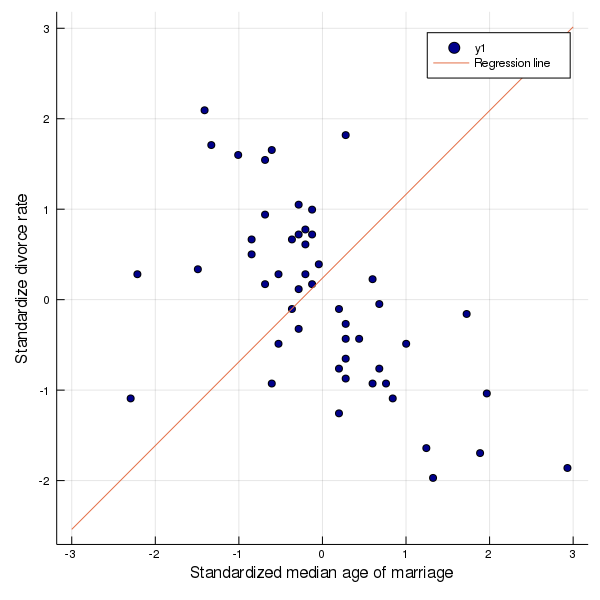

In [9]:
xi = -3.0:0.01:3.0
rws, vars, chns = size(chn)
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[:A], df[:D], color=:darkblue,
  xlab="Standardized median age of marriage",
  ylab="Standardize divorce rate")
plot!(xi, yi, lab="Regression line")

shade(), abline() and link()

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:13
└ @ Core string:13
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:13
└ @ Core string:13


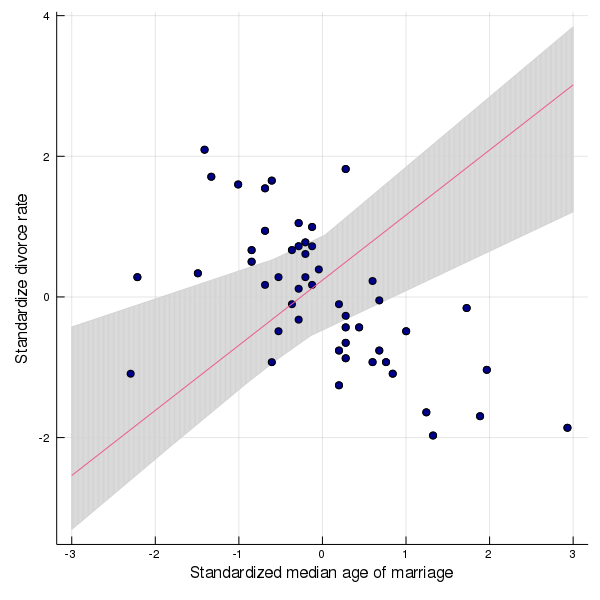

In [10]:
mu = link(xi, chn, [1, 2], mean(xi));
yl = [minimum(mu[i]) for i in 1:length(xi)];
yh =  [maximum(mu[i]) for i in 1:length(xi)];
ym =  [mean(mu[i]) for i in 1:length(xi)];
pi = hcat(xi, yl, ym, yh);
pi[1:5,:]

plot!((xi, yl), color=:lightgrey, leg=false)
plot!((xi, yh), color=:lightgrey, leg=false)
for i in 1:length(xi)
  plot!([xi[i], xi[i]], [yl[i], yh[i]], color=:lightgrey, leg=false)
end
scatter!(df[:A], df[:D], color=:darkblue)
plot!(xi, yi, lab="Regression line")

End of `05/m5.1s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*